In [25]:
import torch
import torch.optim as optim
import torchvision.models.segmentation as segmentation
from utils.dataset_utils import Cataract101Dataset
from torch.utils.data import DataLoader

# Import dataset
cataract_train_ds = Cataract101Dataset(root_folder="data/insegcat-1-v2", split="train")

In [26]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [27]:
# Initialize model
model = segmentation.deeplabv3_resnet50(weights=None, progress=True, num_classes=len(cataract_train_ds.categories), aux_loss=None).to(device)

In [28]:
# Training
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Dataloading
N_WORKERS = 1
BATCH_SIZE = 4
SHUFFLE = True
DROP_LAST = True

In [29]:
# Setup datlaoader
train_loader = DataLoader(cataract_train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=N_WORKERS, drop_last=DROP_LAST, pin_memory=True)

In [50]:
img, mask = cataract_train_ds[0]
img.shape, mask.shape

(torch.Size([3, 720, 1280]), torch.Size([720, 1280]))

In [35]:
(720 - 540) / 2, (1280 - 720) / 2 

(90.0, 280.0)

In [45]:
import torchvision.transforms as TF

transform = TF.Pad((280, 90))
transform(img).shape, transform(mask).shape

(torch.Size([3, 720, 1280]), torch.Size([720, 1280]))

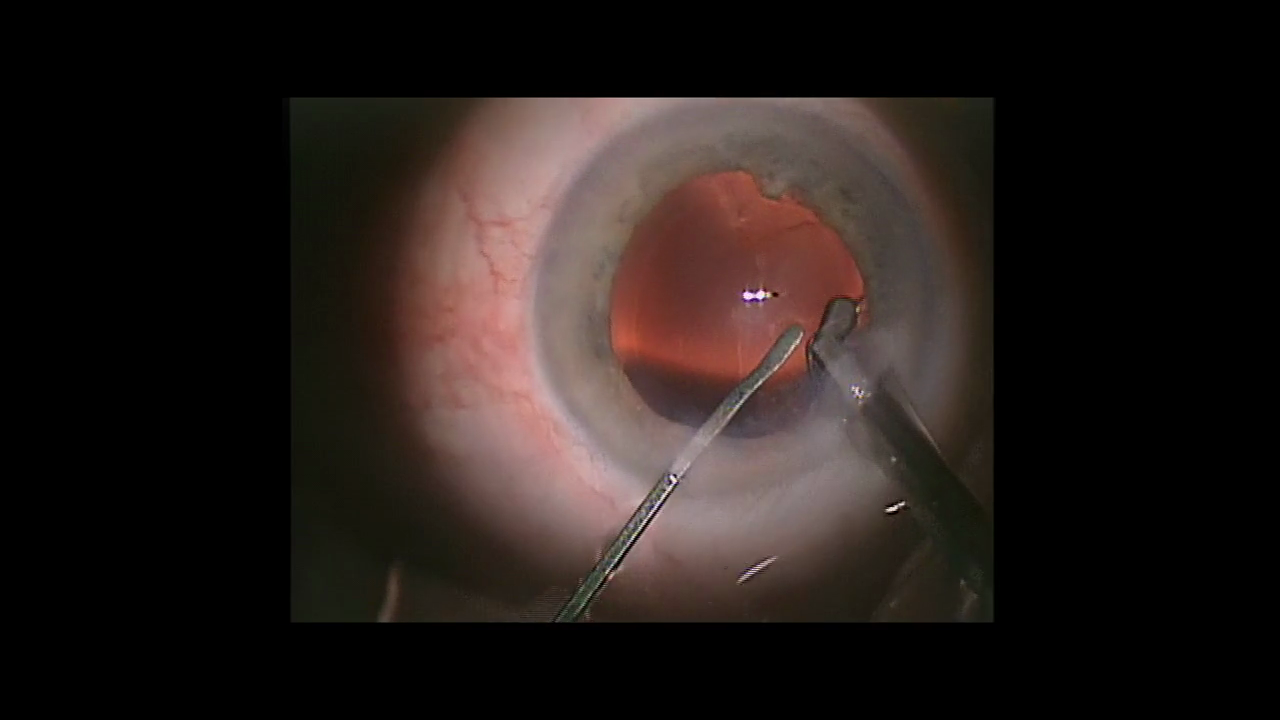

In [49]:
from torchvision.transforms.functional import to_pil_image

to_pil_image(transform(img))

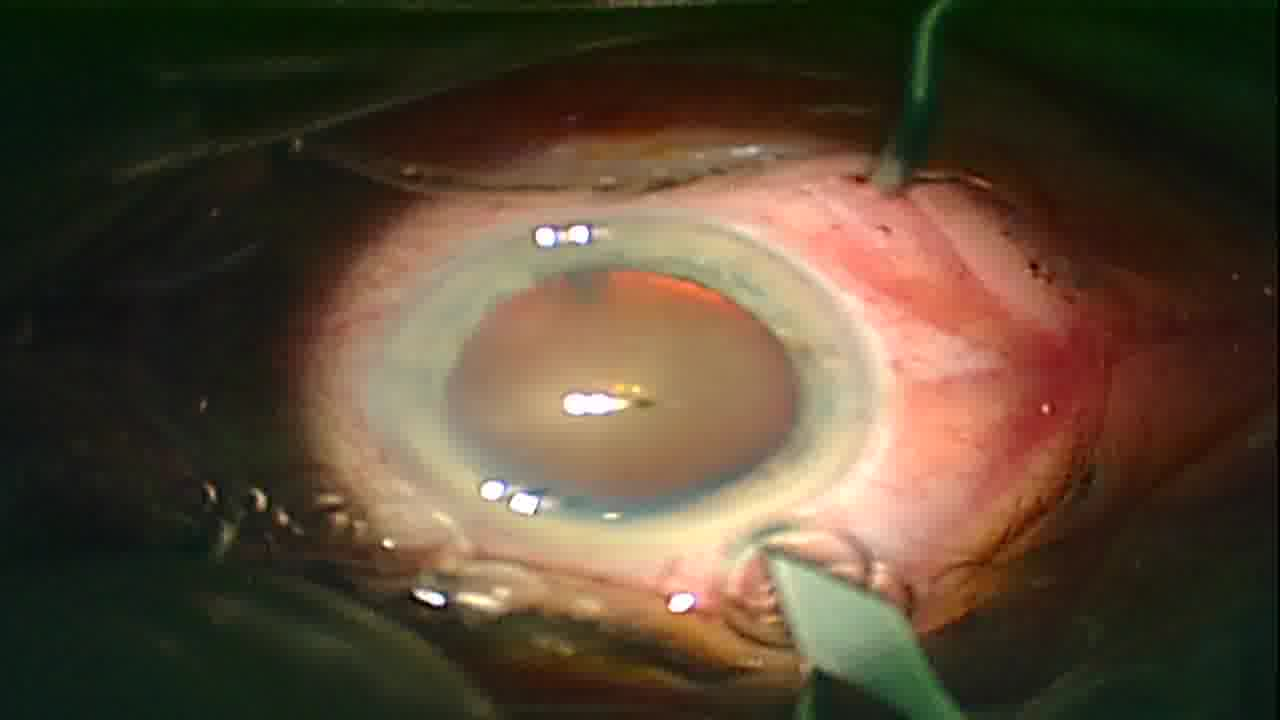

In [51]:
to_pil_image(img)

In [31]:
# 540 x 720
# 720 x 1280

def collate_fn_dl(sample):
    print(sample)
    return sample

# Setup datlaoader
train_loader = DataLoader(cataract_train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST, pin_memory=True, collate_fn=collate_fn_dl)

for img, mask in train_loader:
    break

img.shape, mask.shape

[(tensor([[[0.0157, 0.0196, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0118, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0118, 0.0235,  ..., 0.0078, 0.0000, 0.0000],
         [0.0549, 0.0549, 0.0588,  ..., 0.0078, 0.0000, 0.0000],
         [0.0980, 0.0941, 0.0902,  ..., 0.0118, 0.0000, 0.0000]],

        [[0.1294, 0.1294, 0.1255,  ..., 0.0627, 0.0353, 0.0275],
         [0.1333, 0.1333, 0.1294,  ..., 0.0627, 0.0353, 0.0275],
         [0.1373, 0.1294, 0.1255,  ..., 0.0627, 0.0314, 0.0235],
         ...,
         [0.0824, 0.0863, 0.0863,  ..., 0.0784, 0.0196, 0.0157],
         [0.0902, 0.0902, 0.0824,  ..., 0.0784, 0.0196, 0.0118],
         [0.1020, 0.0980, 0.0902,  ..., 0.0824, 0.0235, 0.0196]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0314,  ..., 0.0000, 0.0000, 0.0000],
         [0.0235, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 

ValueError: too many values to unpack (expected 2)

In [6]:
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    
    for images, masks in train_loader:
        # Move data to the appropriate device (CPU or GPU)
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass and loss
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        print(f'Current loss: {loss.item() * images.size(0):.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}')

Current loss: 11.8595
Current loss: 11.0702
Current loss: 10.6685
Current loss: 9.3348
Current loss: 7.9100
Current loss: 6.6818
Current loss: 5.4127
Current loss: 4.7492
Current loss: 4.1290
Current loss: 3.2264
Current loss: 2.5744
Current loss: 2.5615
Current loss: 1.9092
Current loss: 2.4272
Current loss: 1.7428


KeyboardInterrupt: 

In [15]:
# Sanity check
image, mask = cataract_train_ds[40]

model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))['out']

predictions = output.squeeze(0).argmax(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


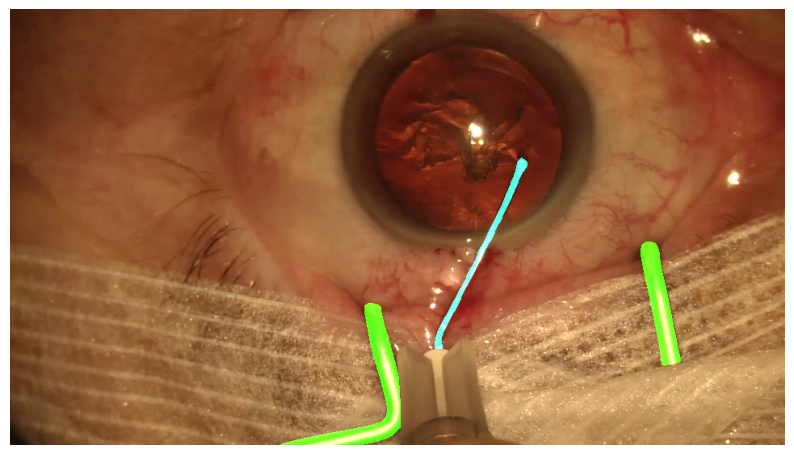

In [16]:
from utils.vis_utils import overlay_mask_on_image

overlay_mask_on_image(image, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


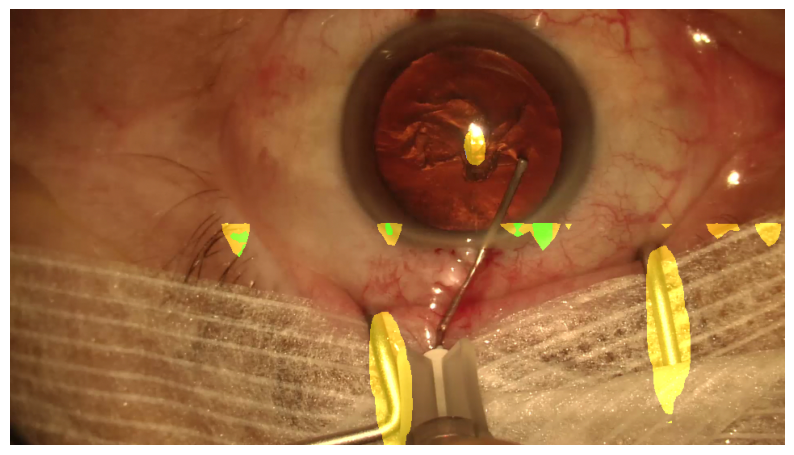

In [17]:
overlay_mask_on_image(image, predictions)